<a href="https://colab.research.google.com/github/mr-alamdari/Multi-Object-Segmentation-Pytorch/blob/main/Multi_Object_Segmentation_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import PIL
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

from skimage.segmentation import mark_boundaries
import albumentations

#1.Data

####Visual Object Classes(VOC) [Dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html)

In [80]:
class VOCS(torchvision.datasets.VOCSegmentation):
  def __getitem__(self, id):
    img = PIL.Image.open(self.images[id]).convert('RGB')
    mask = PIL.Image.open(self.masks[id])

    if self.transforms is not None:
      augmented = self.transforms(image=np.array(img), mask=np.array(mask))
      img = augmented['image']
      mask = augmented['mask']
      mask[mask>20] = 0
    
    img = torchvision.transforms.functional.to_tensor(img)
    mask = torch.from_numpy(mask).type(torch.long)
    return img, mask

In [81]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
h, w = 520, 520

transform_train = albumentations.Compose([albumentations.Resize(h, w),
                                          albumentations.HorizontalFlip(p=0.5),
                                          albumentations.Normalize(mean=mean, std=std)])
transform_val = albumentations.Compose([albumentations.Resize(h, w),
                                      albumentations.Normalize(mean=mean, std=std)])

In [82]:
path2data = '/content/data'
path2models = '/content/models'

if not os.path.exists(path2data):
  os.mkdir(path2data)

if not os.path.exists(path2models):
  os.mkdir(path2models)

In [83]:
train_ds = VOCS(path2data,
                year='2012',
                image_set='train',
                download=True,
                transforms=transform_train)

val_ds = VOCS(path2data, 
              year='2012',
              image_set='val',
              download=True,
              transforms=transform_val)

Using downloaded and verified file: /content/data/VOCtrainval_11-May-2012.tar
Extracting /content/data/VOCtrainval_11-May-2012.tar to /content/data
Using downloaded and verified file: /content/data/VOCtrainval_11-May-2012.tar
Extracting /content/data/VOCtrainval_11-May-2012.tar to /content/data


In [84]:
len(train_ds), len(val_ds)

(1464, 1449)

In [85]:
num_classes = 21
colors = np.random.randint(0, 2, size=(num_classes+1, 3), dtype='uint8')

In [86]:
colors

In [87]:
def re_normalize(x, mean=mean, std=std):
  new_x = x.clone()
  for c, (mean_i , std_i) in enumerate(zip(mean, std)):
    new_x[c] = new_x[c] * std_i + mean_i
  return new_x

In [88]:
def show_img_mask(img, mask):
  plt.figure(figsize=(20, 50))
  renormalized_img = re_normalize(img)

  plt.subplot(1, 3, 1)
  plt.imshow(torchvision.transforms.functional.to_pil_image(renormalized_img))

  plt.subplot(1, 3, 2)
  plt.imshow(mask)

  plt.subplot(1, 3, 3)
  if torch.is_tensor(renormalized_img):
    renormalized_img = torchvision.transforms.functional.to_pil_image(renormalized_img)
    mask = mask.numpy()
  
  for i in range(num_classes):
    mask = (mask==i)
    renormalized_img = mark_boundaries(np.array(renormalized_img),
                          mask,
                          outline_color=colors[i],
                          color=colors[i])
    plt.imshow(renormalized_img)

In [89]:
def show_img(dataset, n=5):
  for i in range(n):
    img, mask = dataset[np.random.randint(len(dataset))]
    show_img_mask(img, mask)

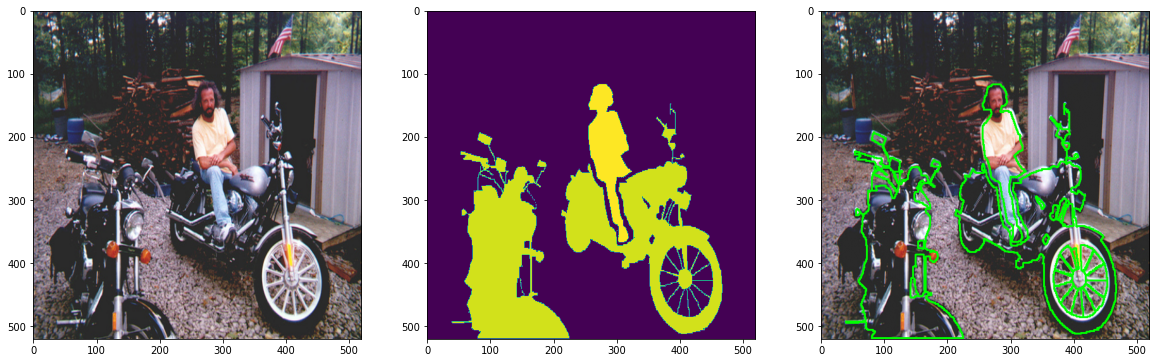

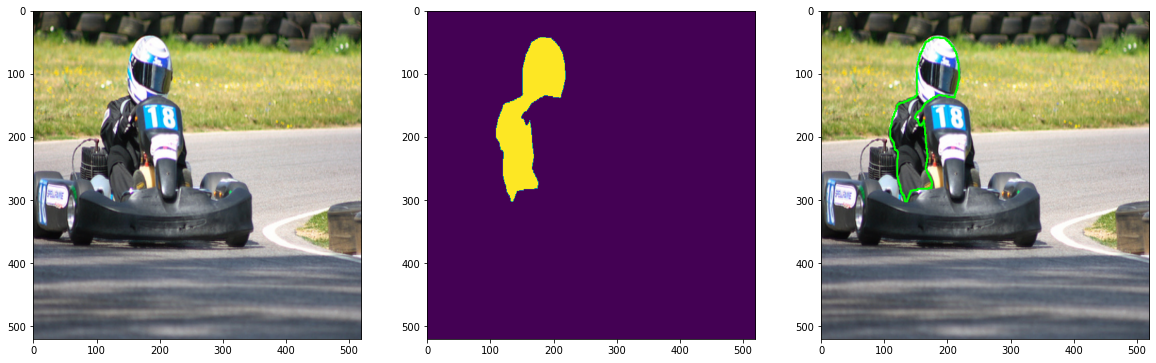

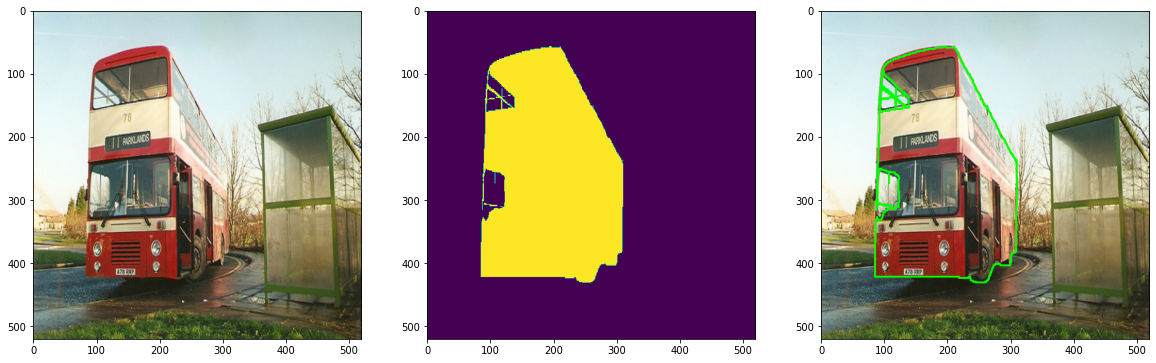

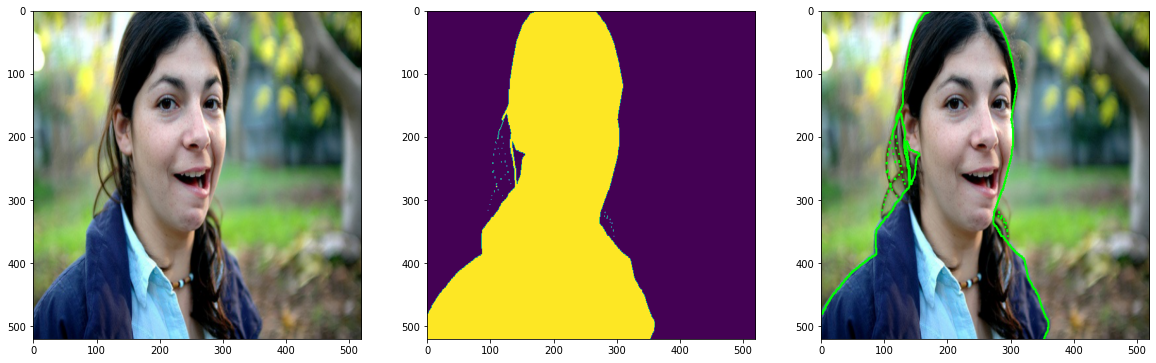

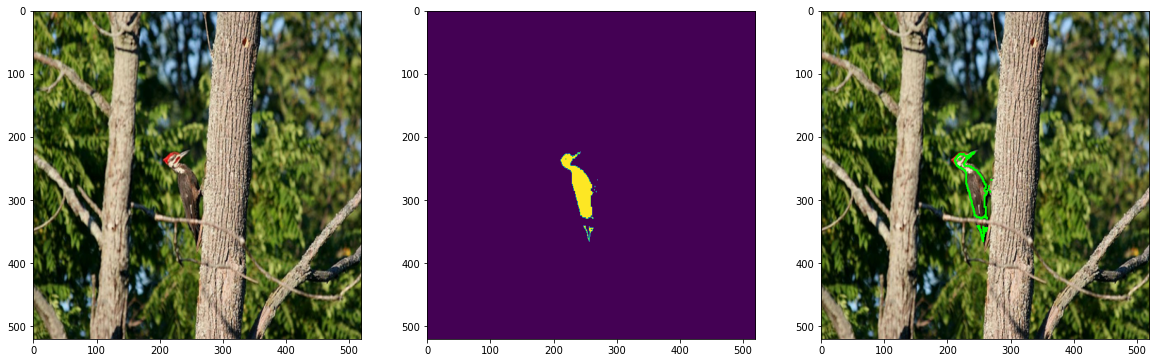

In [90]:
show_img(train_ds, 5)

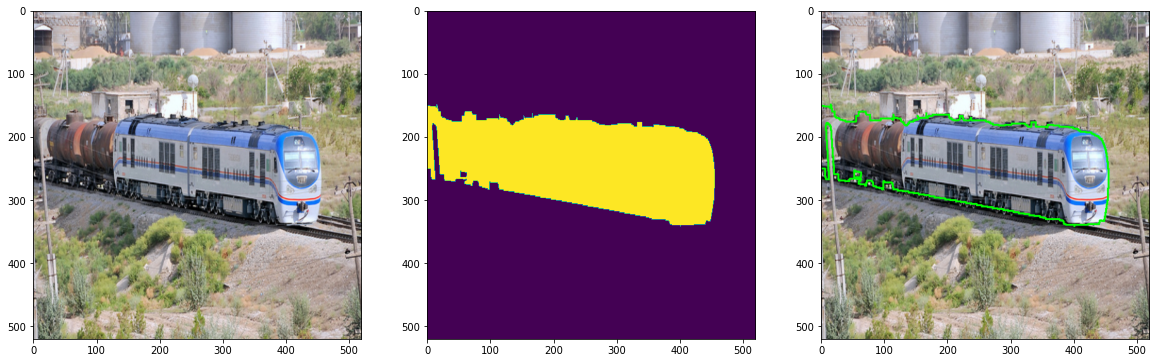

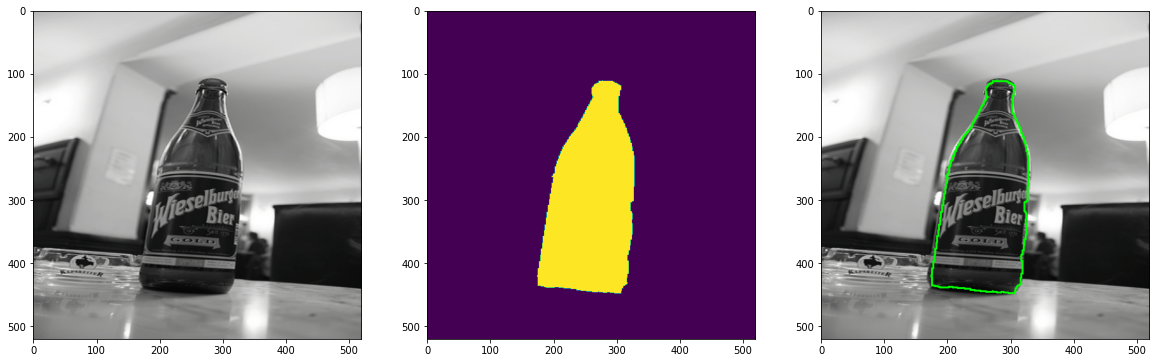

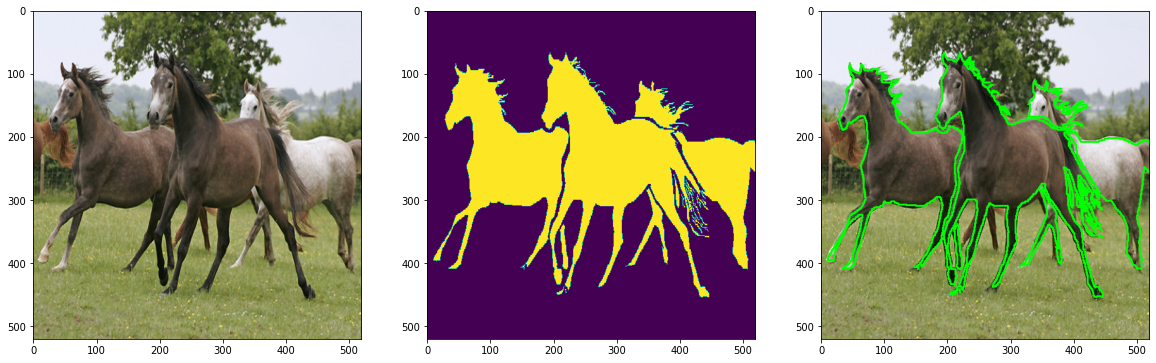

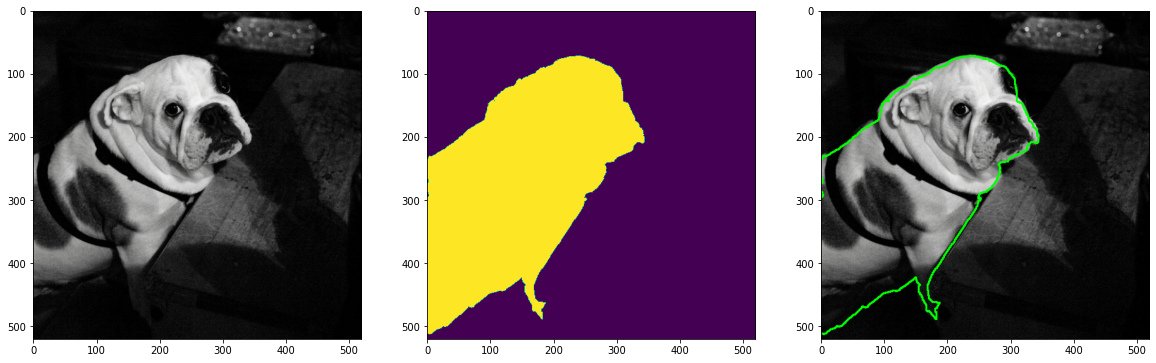

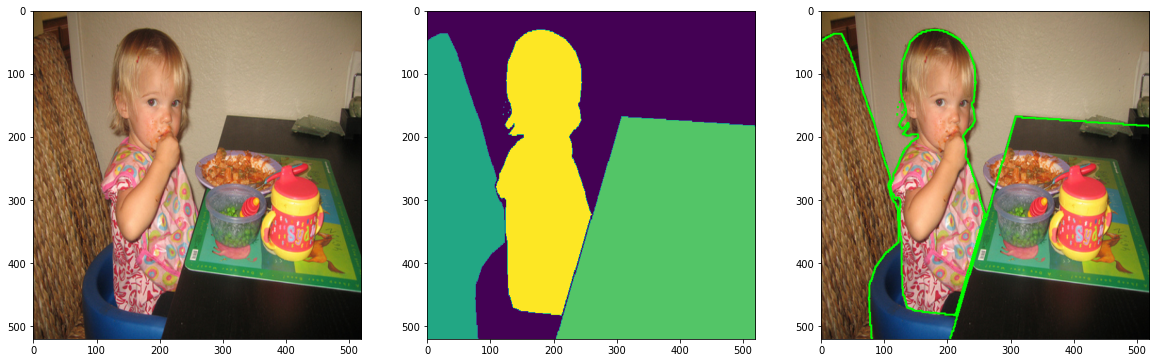

In [91]:
show_img(val_ds, 5)

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False)

In [15]:
for im, mas in train_dl:
  print(im.shape, mas.shape)
  break

torch.Size([4, 3, 520, 520]) torch.Size([4, 520, 520])


In [16]:
for im, mas in val_dl:
  print(im.shape, mas.shape)
  break

torch.Size([8, 3, 520, 520]) torch.Size([8, 520, 520])


#2.Model

In [17]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, num_classes=21)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [19]:
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [21]:
model.eval()
with torch.no_grad():
  for x, y in val_dl:
    img = x.to(device)
    pred = model(img)
    pred = pred['out'].cpu()
    print(pred.shape)
    pred = torch.argmax(pred, axis=1)
    break
  print(pred.shape)

torch.Size([8, 21, 520, 520])
torch.Size([8, 520, 520])


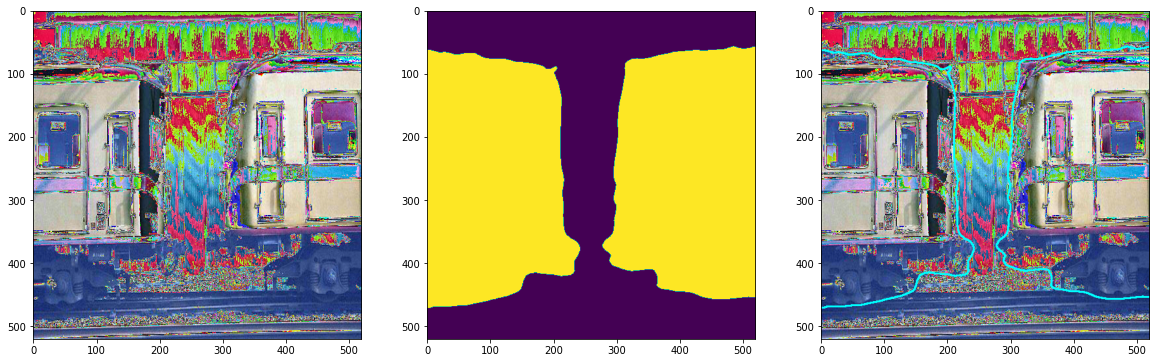

In [22]:
n = np.random.randint(len(pred))
show_img_mask(img[n], pred[n])

In [23]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [25]:
opt = torch.optim.Adam(model.parameters(), lr=1e-6)

In [27]:
torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

In [29]:
current_lr = 1e-06
def get_lr(opt):
  for param_group in opt.praram_groups():
    return param_group['lr']

#3.Training the  Model

In [92]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  len_data = len(dataset_dl.dataset)

  for x, y in dataset_dl:
    x = x.to(device)
    y = y.to(device)

    output = model(x)['out']
    loss = loss_func(output, y)
    if opt is not None:
      opt.zero_grad()
      loss.backward()
      opt.step()

    running_loss += loss
    if sanity_check:
      break
  
  total_loss = running_loss/float(len_data)
  return loss, None